# Price Prediction Model

[*********************100%%**********************]  1 of 1 completed

Data downloaded successfully.


Epoch 1/100
15/15 [==============================] - 4s 58ms/step - loss: 0.0548 - val_loss: 0.1281
Epoch 2/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0117 - val_loss: 0.0158
Epoch 3/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0060 - val_loss: 0.0275
Epoch 4/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0062 - val_loss: 0.0099
Epoch 5/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0053 - val_loss: 0.0117
Epoch 6/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0055 - val_loss: 0.0171
Epoch 7/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0051 - val_loss: 0.0019
Epoch 8/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0044 - val_loss: 0.0011
Epoch 9/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0036 - val_loss: 0.0074
Epoch 10/100
15/15 [==============================] - 0s 14ms/step - loss: 0.0040 - val_loss: 0.0060

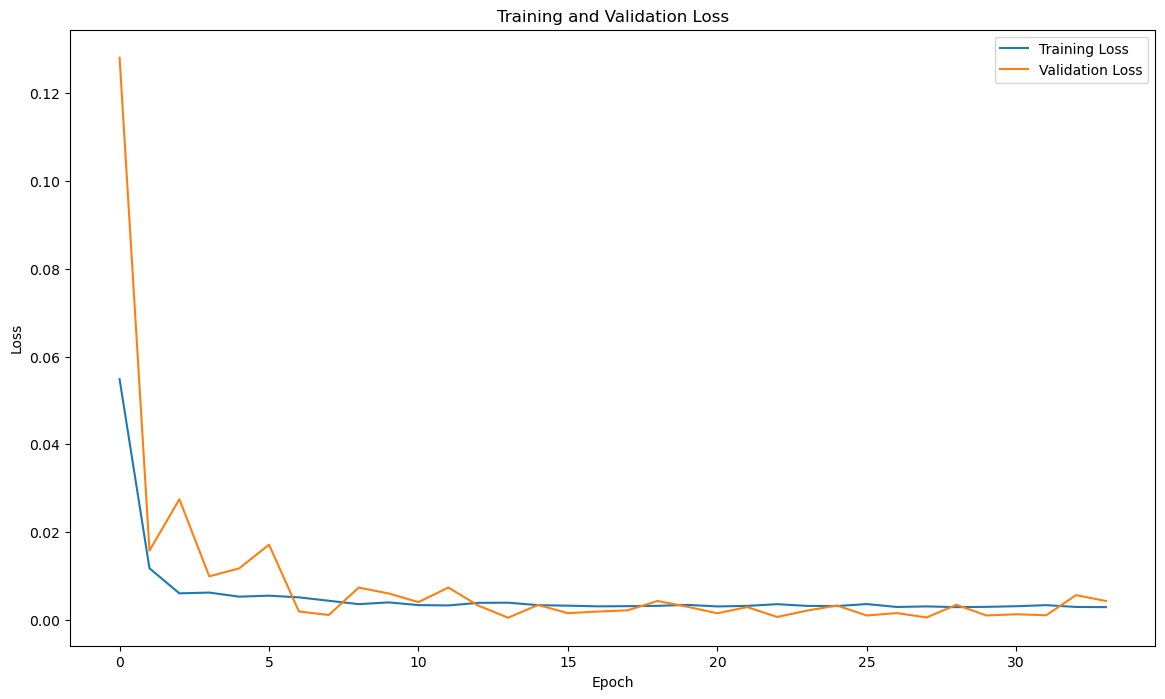

Making predictions...
1/1 [==============================] - 0s 17ms/step
Training MSE: 107906.15559176466
Testing MSE: 28172.318965435028
Training RMSE: 328.49072375299227
Testing RMSE: 167.84611692093156
Training R²: 0.9751348824429408
Testing R²: 0.897316145318801


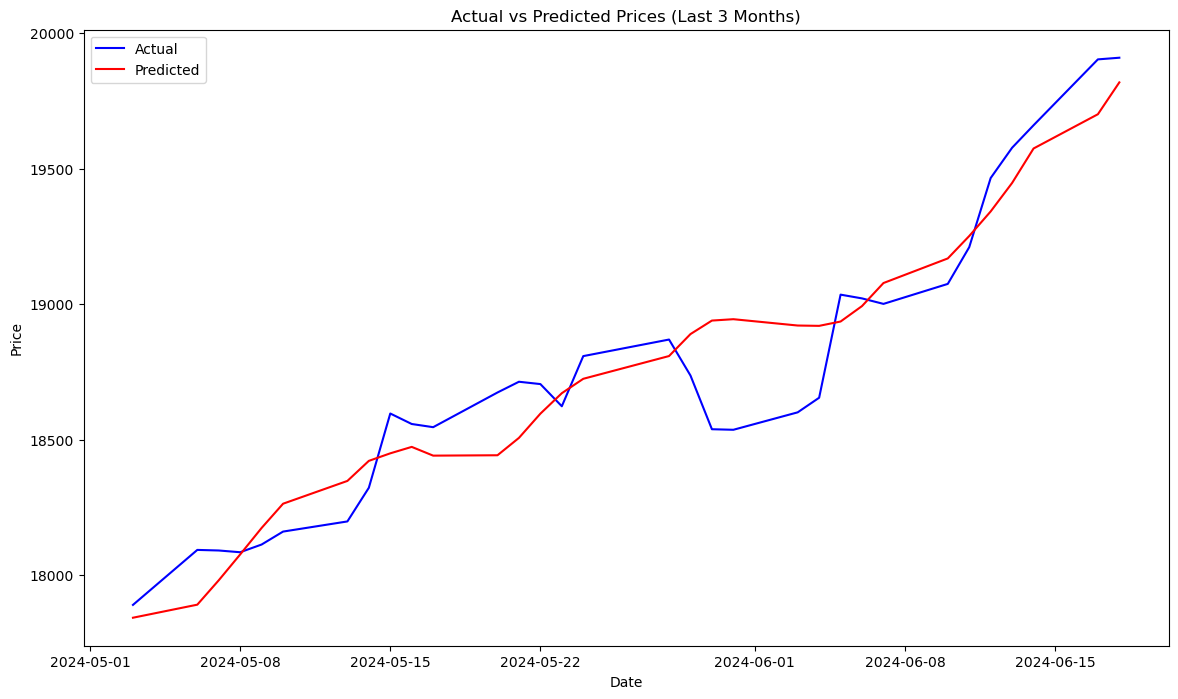

Mean absolute error on test set: 136.7047119140625
Mean absolute error % on test set: 0.73%
R² score: 0.897316145318801


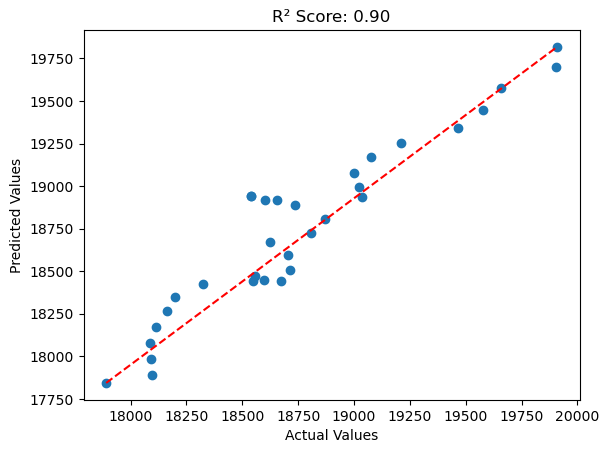

In [16]:
# last 2 years of data for training and the last 3 months
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Download NASDAQ data
START_DATE = '1990-01-02'
END_DATE = '2024-06-21'
TICKER = '^NDX'

print(f"Downloading data for {TICKER}...")
data = yf.download(TICKER, start=START_DATE, end=END_DATE, auto_adjust=True)
print("Data downloaded successfully.")

# Calculate technical indicators
data['EMA_50'] = ta.trend.ema_indicator(data['Close'], window=50)
data['EMA_200'] = ta.trend.ema_indicator(data['Close'], window=200)
data['RSI'] = ta.momentum.rsi(data['Close'], window=14)
data['MACD'] = ta.trend.macd(data['Close'])
data['MACD_Signal'] = ta.trend.macd_signal(data['Close'])
data['MACD_Hist'] = ta.trend.macd_diff(data['Close'])

# Fill NaN values
data.fillna(method='bfill', inplace=True)
data.fillna(method='ffill', inplace=True)

# Select features and target
features = ['Open', 'High', 'Low', 'Volume', 'EMA_50', 'EMA_200', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist']
target = 'Close'

X = data[features].values
Y = data[target].values

# Scale the data
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y.reshape(-1, 1))

# Define function to create datasets for LSTM
def create_dataset(X, Y, time_step=30):
    Xs, Ys = [], []
    for i in range(len(X) - time_step - 1):
        Xs.append(X[i:(i + time_step), :])
        Ys.append(Y[i + time_step, 0])
    return np.array(Xs), np.array(Ys)

# Use last 2 years for training and last 3 months for testing
test_start_date = pd.to_datetime(END_DATE) - pd.DateOffset(months=3)
train_start_date = test_start_date - pd.DateOffset(years=2)

train_data = data[(data.index >= train_start_date) & (data.index < test_start_date)]
test_data = data[data.index >= test_start_date]

# Prepare LSTM datasets
X_train = train_data[features].values
Y_train = train_data[target].values

X_test = test_data[features].values
Y_test = test_data[target].values

# Scale the datasets
X_train_scaled = scaler_X.fit_transform(X_train)
Y_train_scaled = scaler_Y.fit_transform(Y_train.reshape(-1, 1))

X_test_scaled = scaler_X.transform(X_test)
Y_test_scaled = scaler_Y.transform(Y_test.reshape(-1, 1))

# Create LSTM datasets
time_step = 30
X_train_lstm, Y_train_lstm = create_dataset(X_train_scaled, Y_train_scaled, time_step)
X_test_lstm, Y_test_lstm = create_dataset(X_test_scaled, Y_test_scaled, time_step)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train_lstm.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_lstm, Y_train_lstm, epochs=100, batch_size=32, validation_data=(X_test_lstm, Y_test_lstm), callbacks=[early_stopping], verbose=1)

# Plot training and validation loss
plt.figure(figsize=(14, 8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make predictions
print("Making predictions...")
train_predict = model.predict(X_train_lstm)
test_predict = model.predict(X_test_lstm)

# Inverse transform predictions and actual values
train_predict = scaler_Y.inverse_transform(train_predict)
test_predict = scaler_Y.inverse_transform(test_predict)
Y_train_actual = scaler_Y.inverse_transform(Y_train_lstm.reshape(-1, 1))
Y_test_actual = scaler_Y.inverse_transform(Y_test_lstm.reshape(-1, 1))

# Calculate metrics
train_mse = mean_squared_error(Y_train_actual, train_predict)
test_mse = mean_squared_error(Y_test_actual, test_predict)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_r2 = r2_score(Y_train_actual, train_predict)
test_r2 = r2_score(Y_test_actual, test_predict)

print(f'Training MSE: {train_mse}')
print(f'Testing MSE: {test_mse}')
print(f'Training RMSE: {train_rmse}')
print(f'Testing RMSE: {test_rmse}')
print(f'Training R²: {train_r2}')
print(f'Testing R²: {test_r2}')

# Plot predictions for the last 3 months
plt.figure(figsize=(14, 8))
plt.plot(test_data.index[time_step:time_step+len(Y_test_actual)], Y_test_actual, color='blue', label='Actual')
plt.plot(test_data.index[time_step:time_step+len(test_predict)], test_predict, color='red', label='Predicted')
plt.title('Actual vs Predicted Prices (Last 3 Months)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(Y_test_actual, test_predict)
mae_percentage = (mae / np.mean(Y_test_actual)) * 100
print(f"Mean absolute error on test set: {mae}")
print("Mean absolute error % on test set: {:.2f}%".format(mae_percentage))

# Calculate R² score
r2 = r2_score(Y_test_actual, test_predict)
print("R² score:", r2)

# Scatter Plot of Actual vs Predicted Values
plt.scatter(Y_test_actual, test_predict)
plt.plot([min(Y_test_actual), max(Y_test_actual)], [min(test_predict), max(test_predict)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'R² Score: {r2:.2f}')
plt.show()
